# **Introduction to PyTorch**

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

![](../graphics/PyTorch.png)

- PyTorch is a machine learning library developed primarily by Facebook’s artificial intelligence group
- PyTorch is free and open-source, released under the BSD licenses
- Offers fast and efficient tensor and matrix math (like numpy), with extensive support for GPU (unlike numpy). 
- Includes automatic symbolic gradient computation.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## 0. Why PyTorch?

In my career in ML to date, I've used 4 libraries extensively, starting around 2012:

1. My own crappy python library
2. Caffe 
3. Tensorflow
4. Pytorch

The biggest switch for me was probably from Caffe to tensorflow in 2016. Tensorflow dramatically improved deep learning workflows, and for me, was siginificantly easier to use (and install!) than Caffe. I was a die-hard tensorflow user until 2019, and got very comfortable with tensorflow workflows. In early 2019, I started closely following Jeremy Howard's work at fastai. This led me to begin experimenting with PyTorch. I tried out PyTorch and fastai on a work project where I had already implemented a solution in Keras + Tensorflow, and was absolutely blown away. In dramatically less time, I was able to achieve significantly better performance. I was sold. 

There is of course no perfect Deep Learning library, and I'm sure something will come along that will displace PyTorch sooner or later (Swift? Tensorflow 2.0?), but in 2019 as a deep learning practitioner, I really believe that PyTorch is worth investing time in. In my own work I found PyTorch to be a better tool for me for these reasons:

**1. Develop Models Far More Interactively.** Because PyTorch is faster and more interactive by design (especially wrapped with fastai), I find it much easier to work in a more "interactive modeling paradigm", where I'm able to quickly try things out, iterate, and make small adjustments, instead of running experiments "in batch" for hours at a time. 

**2. Pythonic Syntax.** Even after using Tensorflow heavily for 3 years, the PyTorch programming patterns just feel more natural, let me move faster, and focus more on the actual modeling.

**3. Faster Training.** For many of the problems I work on, I've found Pytorch to be faster than my equivalent tensorflow implementation.

**4. Dynamic Graphs.** PyTorch graphs are dynamic by design - meaning there's far less notion of "Build the Graph" then "Train the Graph" as we see in tensorflow. 

**5. fastai** The fastai library is a terrific tool, especially for rapid experimentation, and since 2017 is built on PyTorch.


Finally, there's a [great post from Jeremy Howard](https://www.fast.ai/2017/09/08/introducing-pytorch-for-fastai/) explaining why they chose PyTorch for fastai. 

## 1. Baseline Network in Numpy
---

- In our [Neural Networks Demystified](https://github.com/unccv/neural_networks) session, we built a simple neural network (multi-layer perceptron) in Numpy. 
- Our `Neural_Network` ended up requiring ~60 lines, and we needed another ~20 lines to train our network:

In [8]:
import numpy as np
from matplotlib.pyplot import *

In [9]:
class Neural_Network(object):
    def __init__(self, inputLayerSize = 2, outputLayerSize = 1, hiddenLayerSize = 3):        
        #Define Hyperparameters
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [10]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

#Normalize Data
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

Let's use plain gradient descent to estabilish a baseline here:

In [13]:
num_iterations = 1000; lr = 1e-2

losses = []
NN = Neural_Network()
for i in range(num_iterations):
    grads = NN.computeGradients(X,y)
    params = NN.getParams()
    NN.setParams(params - lr*grads)
    losses.append(NN.costFunction(X,y ))

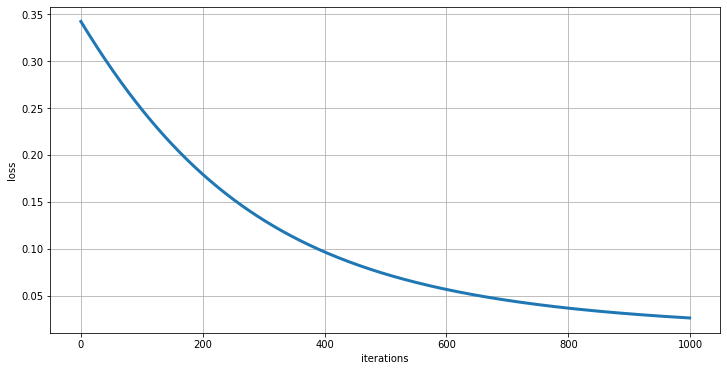

In [14]:
fig = figure(0, (12,6))
plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');

In [16]:
# yhat = NN.forward(X)
# print(y.T, yhat.T)

## 2. PyTorch as "Numpy with GPU Support"
----

- PyTorch offers some really nice high-level functions that we'll get into shortly, but if you're familiar with Numpy, it can be helpful to first think of PyTorch as "Numpy with GPU Support", allowing us to train large (and deep) neural networks much faster due to the massive parallelism of modern GPUs.
- PyTorch replaces the numpy multidimensional array `numpy.ndarray` with `torch.tensor`.
- Let's have a look at how we can create and perform operations on Pytorch tensors. 
- Notice how syntactically similar these operations are to numpy operations - this is part of what people mean when they describe Pytorch as "Pythonic".

In [17]:
import torch

In [18]:
a = torch.zeros(3,3)
a

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [19]:
a.shape

torch.Size([3, 3])

In [20]:
b = torch.ones(3,3)
b

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

We can perform mathematical oprations on our tensors using methods from the Pytorch library, or by using simple python syntax as we would with numpy:

In [21]:
torch.add(a, b)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [22]:
a+b

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

Happily, we can use Numpy style indexing on torch tensors:

In [23]:
a[:,1]

tensor([0., 0., 0.])

One syntax difference from Numpy that you'll encounter frequently is `torch.view` instead of `numpy.reshape`:

In [24]:
a.view(9)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])

We can also easilty convert between numpy arrays and torch tensors:

In [25]:
#Torch to numpy
a.numpy()

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [26]:
#Numpy to Torch:
torch.tensor(np.random.randn(3,3))

tensor([[ 1.8131,  0.0144,  0.1990],
        [-0.3323,  0.8052,  0.3829],
        [ 0.9444,  0.0726,  1.6255]], dtype=torch.float64)

Finally, moving our data to and from GPU is really simple using the PyTorch `.to` method.

In [27]:
# Only runs if cuda is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    a = a.to(device)                       # or just use strings ``.to("cuda")``
    b = b.to(device)
    c = a + b                              # Now this operation will happen on GPU
    print(c)
    print(c.to("cpu"))                     #Bring back to CPU     

## 3. Simple Neural Network Forward Pass in Pytorch
---

- Switching our numpy nueral network to Pytorch is really simple. 
- We'll start by just replacing our numpy variables and operations with their PyTorch counterparts
- We'll start with our forward methods, and then use some higher level Torch tools to streamline our backpropogation and training

In [28]:
class Neural_Network_Torch(object):
    def __init__(self, inputLayerSize = 2, outputLayerSize = 1, hiddenLayerSize = 3):        
        #Define Hyperparameters
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        
        #Weights (parameters)
        self.W1 = torch.randn(self.inputLayerSize, self.hiddenLayerSize)
        self.W2 = torch.randn(self.hiddenLayerSize, self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = torch.mm(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = torch.mm(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+torch.exp(-z))

- How many lines did we change?
- What do you think `torch.mm` does?
- Let's test our Pytorch Network

In [29]:
#Let's call our Pytorch Nueral Network "NT"
NT = Neural_Network_Torch()

#Must pass in a PyTorch Tensor into our PyTorch network:
X_tensor = torch.tensor(X, dtype = torch.float)

#Go ahead and make a tensor version of our prediciton targets:
y_tensor = torch.tensor(y, dtype = torch.float)

In [30]:
NT.forward(X_tensor)

tensor([[0.4824],
        [0.4391],
        [0.4784],
        [0.4536]])

- Note that these outputs won't exactly match our numpy neural network's outputs, because each network has a different random intialization.

## 3. Automatic Differentiation in PyTorch
---

- This is where libraries like PyTorch and Tensorflow get really cool. 
- In our [Neural Networks Demystified](https://github.com/unccv/neural_networks) session, we spend **alot** of time learning how to compute the gradient of our loss function with respect to our weights, allowing us to train our neural network by **gradient descent**. 
- Further, we only did this for **one architecture**, if we had to manually recompute our gradients each time we changed our architecture - this would become quite time consuming!
- So far we discussed how PyTorch tensors can be used just like numpy arrays, but can be easily moved the GPU for parallel/accelerated computations. 
- PyTorch tensors also support [automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py), which is going to allow us to **automatically compute gradients** across our neural network.
- Let's see how this works with a simple example. Let's start with math, and then move to code. First, find $\frac{\partial B}{\partial A}$:

$$
A = \begin{bmatrix}
    a_1\\
    a_2\\
    a_3\\
    \end{bmatrix}
\quad\quad
B = |A|^2 = \sum a_i^2 = a_1^2 + a_2^2 + a_3^2
\quad\quad
\frac{\partial B}{\partial A} = 
\begin{bmatrix}
    \frac{\partial B}{\partial a_1}\\
    \frac{\partial B}{\partial a_2}\\
    \frac{\partial B}{\partial a_3}\\
\end{bmatrix}
= ?
$$


![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

----

- Answer: 
$$
\frac{\partial B}{\partial A} = \begin{bmatrix}
    2 a_1\\
    2 a_2\\
    2 a_3\\
\end{bmatrix}
$$

---

- Now, let's see how Pytorch can automatically compute this for us:

In [31]:
import torch

In [32]:
#By setting require_grad = True, a will also keep track of its own gradient!
A = torch.randn(3, 1, requires_grad = True) 
A

tensor([[ 0.0487],
        [-0.0175],
        [ 1.6828]], requires_grad=True)

In [33]:
B = torch.sum(A**2)

In [34]:
B

tensor(2.8344, grad_fn=<SumBackward0>)

Alright, ready?

In [35]:
B.backward()

- With this one line, Pytorch has both computed our gradient function analytically, and computed the value of $\frac{\partial B}{\partial A}$ for our specific values of $A$ and $B$!
- Gradients are stored in the `.grad` field of our tensors:

In [36]:
A.grad

tensor([[ 0.0974],
        [-0.0350],
        [ 3.3656]])

In [37]:
#Does PyTorch's gradient match our analytical gradient?
2*A

tensor([[ 0.0974],
        [-0.0350],
        [ 3.3656]], grad_fn=<MulBackward0>)

- Finally, an important point about how **gradients accumulate**.
- This next step may seem a little strange, but happens in training looks all the time
- If we re-declare our function `B = torch.sum(A**2)` (we could also pass `retain_graph=True` into our first `backward` call), and call `backward()` again, watch what happens to our gradients:

In [38]:
B = torch.sum(A**2)
B.backward()

In [39]:
A.grad

tensor([[ 0.1947],
        [-0.0701],
        [ 6.7311]])

- Why did our gradients change like this?
- Why do you think this was chosen to be the **default pytorch behavior?**
- Why might this be problematic when training a neural network with backpropogation?

![](../graphics/spacer_small.png)

---

- As we train our neural network, we need to be aware of this behavior - PyTorch tensors will **accumulate** all gradients. 
- Each time we call `.backward`, new gradient values will be added to old ones. 
- If this is not the behavior we want, we can reset our accumulators with `.grad.zero_`:

In [40]:
A.grad

tensor([[ 0.1947],
        [-0.0701],
        [ 6.7311]])

In [41]:
A.grad.zero_(); #Note that "_" at the end of most pytorch operators means "perform in place"

In [42]:
A.grad

tensor([[0.],
        [0.],
        [0.]])

- So we've now seen how PyTorch can automatically compute and store gradients.
- This is, of course, a really simple example
- What's really exciting here is that using Pytorch, we can chain together many operations, and PyTorch will automatically compute the gradient accross **all the operations we chain together.**
- In the next section, we'll see how this works on our simple Pytorch neural network.

## 4. Let's Use Pytorch to Compute the Gradients of Our Network
---

In [47]:
class Neural_Network_Torch(object):
    def __init__(self, inputLayerSize = 2, outputLayerSize = 1, hiddenLayerSize = 3):        
        #Weights (parameters)
        self.W1 = torch.randn(inputLayerSize, hiddenLayerSize, requires_grad = True)
        self.W2 = torch.randn(hiddenLayerSize, outputLayerSize, requires_grad = True)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = torch.mm(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = torch.mm(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+torch.exp(-z))

In [48]:
# X = (hours sleeping, hours studying), y = Score on test
X = torch.tensor(([3,5], [5,1], [10,2], [6,1.5]), dtype=torch.float)
y = torch.tensor(([75], [82], [93], [70]), dtype=torch.float)

max_values, max_indices = torch.max(X, dim=0) #Normalize Data
X = X/max_values
y = y/100 #Max test score is 100

NT = Neural_Network_Torch()

In [49]:
yhat = NT.forward(X)
loss = torch.sum(0.5*(y-yhat)**2)

In [50]:
loss

tensor(0.4672, grad_fn=<SumBackward0>)

- Notice that our loss is now a tensor with a `grad_fn`.
- Now, to compute the gradients of our loss with respect to our weights, all we have to do is call `loss.backward()`!

In [51]:
loss.backward()

In [52]:
NT.W1.grad

tensor([[-0.0093,  0.0361,  0.0892],
        [-0.0064,  0.0323,  0.0658]])

In [53]:
NT.W2.grad

tensor([[-0.1877],
        [-0.0857],
        [-0.1786]])

- Pretty cool, right? Remember how much work this took us when we only used numpy!
- Now, let's put all this together and train our network using gradient descent.

In [54]:
num_iterations = 1000
lr = 1e-2

losses = []
NT = Neural_Network_Torch()
for i in range(num_iterations):
    yhat = NT.forward(X)
    loss = torch.sum(0.5*(y-yhat)**2)
    loss.backward() #Compute Gradients
    
    # After we compute our gradients, we don't want torch to track the 
    # gradients when we actually perfrom gradient descent:
    with torch.no_grad(): 
        NT.W1 -= NT.W1.grad * lr #Gradient Descent
        NT.W2 -= NT.W2.grad * lr
        NT.W1.grad.zero_(); NT.W2.grad.zero_(); #Zero Gradients
        losses.append(loss.item())

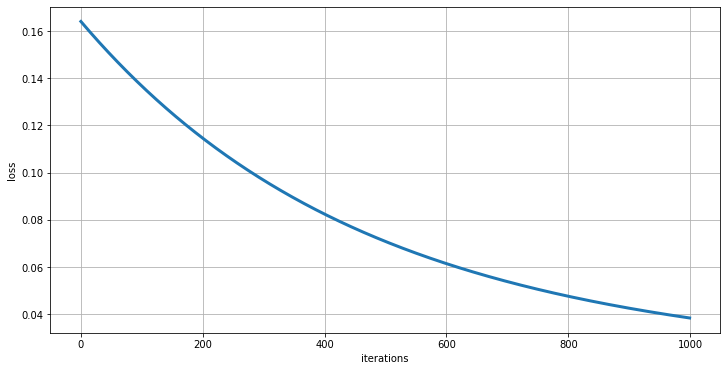

In [55]:
fig = figure(0, (12,6))
plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');

- Pretty cool, right?
- Using Torch's automatic differentiation, we've been able to greatly simply our Neural Network class, while simultaneously enabling computation on GPU. 
- Next, we'll move on to using higher level Torch tools. 

## 5. Simpler and More Powerful Models with nn.Module

- Now that we have our basic neural network working in PyTorch, we'll now refactor using various high-level PyTorch tools. 
- At each step our code should become more concise, more understandable, more flexible, and/or faster. 
- We'll start with nn.Module, a really nice neural network class that we can inherit our class from, providing some nice methods. Let's see how it works. 

In [56]:
from torch import nn

In [57]:
class Neural_Network_Torch(nn.Module):
    def __init__(self, inputLayerSize = 2, outputLayerSize = 1, hiddenLayerSize = 3):        
        super().__init__()
        #Using nn.Parameter will let use use some higher level nn.Module methods:
        self.W1 = nn.Parameter(torch.randn(inputLayerSize, hiddenLayerSize))
        self.W2 = nn.Parameter(torch.randn(hiddenLayerSize, outputLayerSize))
        
    def forward(self, X):
        #Propagate inputs though network
        self.a2 = torch.sigmoid(torch.mm(X, self.W1))
        return torch.sigmoid(torch.mm(self.a2, self.W2))

- First, notice how much shorter our class is getting!
- Inheriting from the `nn.Module` class will give us some new methods, shown below, `.parameters()`, and `.zero_grad()`. 
- We've replaced our own sigmoid method with Torch's 

In [58]:
NT = Neural_Network_Torch()

In [59]:
# We can iterate through all our parameters at once - 
# this is critical for deep networks with lots of weight matrices:
for p in NT.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1395, -0.5172,  1.4753],
        [ 0.1410, -0.7735, -0.1522]], requires_grad=True)
Parameter containing:
tensor([[-0.1389],
        [-0.5719],
        [ 0.5959]], requires_grad=True)


In [62]:
# Ww can also zero all of our gradients at once now:
NT.zero_grad()

In [63]:
#Note that we can also call our network as a "function" without expclicitly using the forward method:
NT(X)

tensor([[0.5258],
        [0.5246],
        [0.5570],
        [0.5330]], grad_fn=<SigmoidBackward>)

In [64]:
NT.forward(X)

tensor([[0.5258],
        [0.5246],
        [0.5570],
        [0.5330]], grad_fn=<SigmoidBackward>)

Let's put all this together and train our simplified neural network:

In [65]:
num_iterations = 1000
lr = 1e-2

losses = []
NT = Neural_Network_Torch()
for i in range(num_iterations):
    yhat = NT(X)
    loss = torch.sum(0.5*(y-yhat)**2)
    loss.backward() #Compute Gradients
    
    # After we compute our gradients, we don't want torch to track the 
    # gradients when we actually perfrom gradient descent:
    with torch.no_grad(): 
        for p in NT.parameters():
            p -= p.grad *lr
        NT.zero_grad() #Zero Gradients
        losses.append(loss.item())

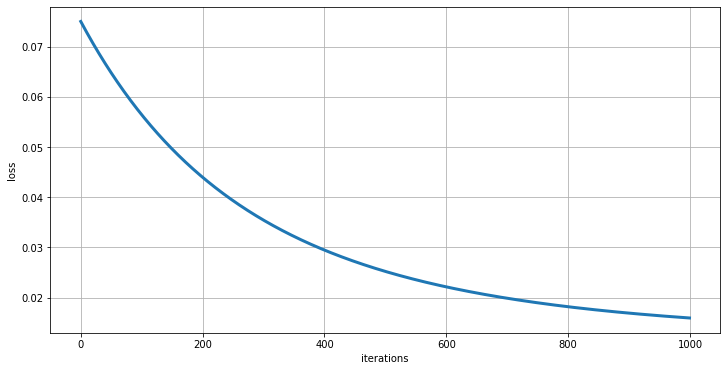

In [66]:
fig = figure(0, (12,6))
plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');

## 6. PyTorch Layers

- Pytorch has lots of nice predifined neural networks layers
- The layer type we're using now corresponds to a PyTorch `nn.Linear` layer.
- PyTorch layers automatically create our parameter tensors for us, and are often faster then manual implementations. 

In [67]:
class Neural_Network_Torch(nn.Module):
    def __init__(self, inputLayerSize = 2, outputLayerSize = 1, hiddenLayerSize = 3):        
        super().__init__()
        #Using nn.Parameter will let use use some higher level nn.Module methods:
        self.lin1 = nn.Linear(inputLayerSize, hiddenLayerSize)
        self.lin2 = nn.Linear(hiddenLayerSize, outputLayerSize)
        
    def forward(self, X):
        #Propagate inputs though network
        a2 = torch.sigmoid(self.lin1(X)) #We can pass our input directly into our PyTorch Layers
        return torch.sigmoid(self.lin2(a2))

In [68]:
num_iterations = 1000; lr = 1e-2; losses = []

NT = Neural_Network_Torch()
for i in range(num_iterations):
    yhat = NT(X)
    loss = torch.sum(0.5*(y-yhat)**2)
    loss.backward() #Compute Gradients
    
    # After we compute our gradients, we don't want torch to track the 
    # gradients when we actually perfrom gradient descent:
    with torch.no_grad(): 
        for p in NT.parameters():
            p -= p.grad *lr
        NT.zero_grad() #Zero Gradients
        losses.append(loss.item())

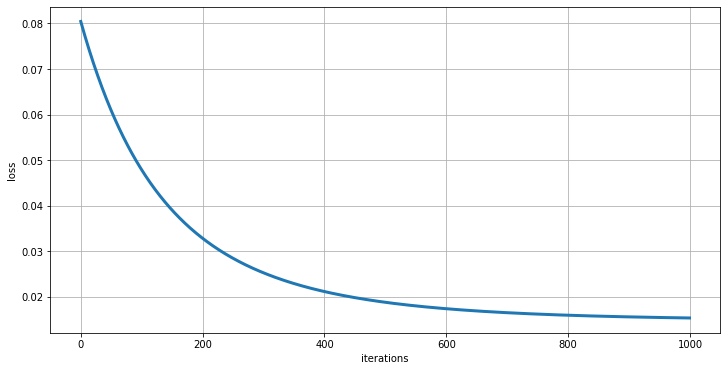

In [69]:
fig = figure(0, (12,6))
plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');

## 7. PyTorch Optim

- Torch includes various optimization algorithms in `torch.optim`.
- These will allow us to easily implement more sophisticated optimizers, and replace the `p -= p.grad *lr` with a simple call to optim's `step()` method.

In [70]:
from torch import optim

In [71]:
num_iterations = 1000; lr = 1e-2; losses = []

NT = Neural_Network_Torch()
opt = optim.SGD(NT.parameters(), lr=lr) #pass in the parameters we want to optimize. 

for i in range(num_iterations):
    yhat = NT(X)
    loss = torch.sum(0.5*(y-yhat)**2)
    loss.backward() #Compute Gradients
    
    opt.step() #Take a gradient descent "step", note that we no longer need torch.no_grad() here.
    opt.zero_grad()
    losses.append(loss.item())

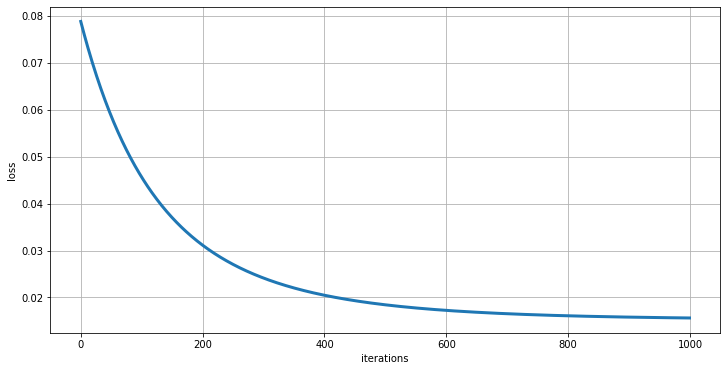

In [72]:
fig = figure(0, (12,6))
plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');

## 8. nn.Sequential

- Finally, let's look at a really nice/simple altrenative way to setup models in PyTorch. 
- Using nn.Sequential, we can create a model by just passing in Pytorch Layers sequentially:

In [73]:
inputLayerSize, hiddenLayerSize, outputLayerSize = 2, 3, 1

model = nn.Sequential(nn.Linear(inputLayerSize, hiddenLayerSize),
                       nn.Sigmoid(), 
                       nn.Linear(hiddenLayerSize, outputLayerSize),
                       nn.Sigmoid())

In [78]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.1351,  0.0429],
        [-0.2056,  0.1341],
        [-0.4413,  0.6075]], requires_grad=True)
Parameter containing:
tensor([-0.2612,  0.5620, -0.2691], requires_grad=True)
Parameter containing:
tensor([[ 0.6953,  0.6479, -0.1419]], requires_grad=True)
Parameter containing:
tensor([0.6572], requires_grad=True)


In [79]:
num_iterations = 1000; lr = 1e-2; losses = []

opt = optim.SGD(model.parameters(), lr=lr) #pass in the parameters we want to optimize. 
for i in range(num_iterations):
    yhat = model(X)
    loss = torch.sum(0.5*(y-yhat)**2)
    loss.backward() #Compute Gradients
    
    opt.step() #Take a gradient descent "step", note that we no longer need torch.no_grad() here.
    opt.zero_grad()
    losses.append(loss.item())

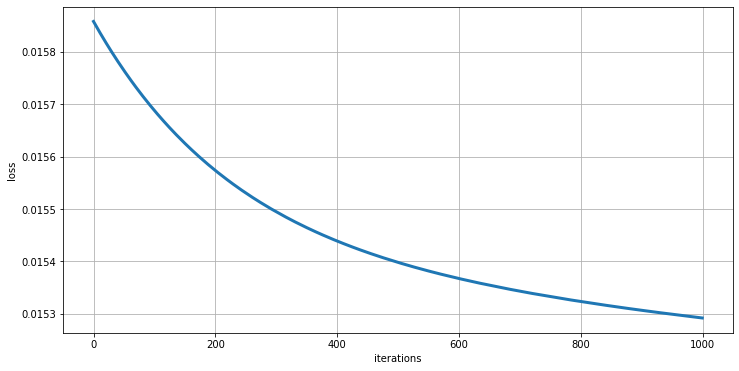

In [80]:
fig = figure(0, (12,6))
plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');

## The End
- Enjoy using Pytorch! 